## Sentiment Analysis using LSTM

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

In [29]:
df = pd.read_csv("hf://datasets/AhmedSSoliman/sentiment-analysis-for-mental-health-Combined-Data/sentiment-analysis-for-mental-health-Combined Data.csv")
df.columns.values[0] = "id" 
df = df.dropna(subset=["statement"])

print(df.head())

   id                                          statement   status
0   0                                         oh my gosh  Anxiety
1   1  trouble sleeping, confused mind, restless hear...  Anxiety
2   2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3   3  I've shifted my focus to something else but I'...  Anxiety
4   4  I'm restless and restless, it's been a month n...  Anxiety


### Preprocess the status

In [30]:
le = LabelEncoder()
df['labeled_status'] = le.fit_transform(df['status'])  

### Preprocess the text data

In [31]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r"http\S+", "", text)  
    text = re.sub(r"[^a-zA-Z\s]", "", text)  
    text = " ".join([word for word in text.split() if word not in stop_words])  
    return text

df["cleaned_text"] = df["statement"].apply(preprocess_text)  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yaxuanhuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
X = df["cleaned_text"]
y = df["labeled_status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vocab_size = 5000
embedding_dim = 200
max_length = 200

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length)

y_train_onehot = to_categorical(y_train, num_classes=7)
y_test_onehot = to_categorical(y_test, num_classes=7)

### Implement the LSTM

In [33]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(7, activation="softmax")  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_seq, y_train_onehot, epochs=5, batch_size=32, validation_data=(X_test_seq, y_test_onehot))

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1317/1317 ━━━━━━━━━━━━━━━━━━━━ 367s 277ms/step - accuracy: 0.5633 - loss: 1.0681 - val_accuracy: 0.6815 - val_loss: 0.7792
Epoch 2/5
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 354s 269ms/step - accuracy: 0.7184 - loss: 0.7070 - val_accuracy: 0.7356 - val_loss: 0.6930
Epoch 3/5
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 341s 259ms/step - accuracy: 0.7914 - loss: 0.5519 - val_accuracy: 0.7646 - val_loss: 0.5986
Epoch 4/5
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 950s 722ms/step - accuracy: 0.8309 - loss: 0.4538 - val_accuracy: 0.7724 - val_loss: 0.5960
Epoch 5/5
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 991s 753ms/step - accuracy: 0.8535 - loss: 0.3888 - val_accuracy: 0.7736 - val_loss: 0.6220


### Evaluate the model

In [34]:
loss, acc = model.evaluate(X_test_seq, y_test_onehot)
print(f"Test Accuracy: {acc:.2f}")

330/330 ━━━━━━━━━━━━━━━━━━━━ 32s 97ms/step - accuracy: 0.7758 - loss: 0.6178
Test Accuracy: 0.77


In [35]:
y_pred_prob = model.predict(X_test_seq)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

330/330 ━━━━━━━━━━━━━━━━━━━━ 29s 86ms/step


In [37]:
label_names = ['Normal', 'Anxiety', 'Depression', 'Suicidal', 'Stress', 'Bipolar', 'Personality disorder']

report = classification_report(y_true, y_pred, target_names=label_names)
print(report)

                      precision    recall  f1-score   support

              Normal       0.85      0.78      0.81       755
             Anxiety       0.81      0.83      0.82       527
          Depression       0.73      0.73      0.73      3016
            Suicidal       0.91      0.92      0.92      3308
              Stress       0.80      0.58      0.67       237
             Bipolar       0.55      0.62      0.58       536
Personality disorder       0.66      0.64      0.65      2158

            accuracy                           0.77     10537
           macro avg       0.76      0.73      0.74     10537
        weighted avg       0.77      0.77      0.77     10537



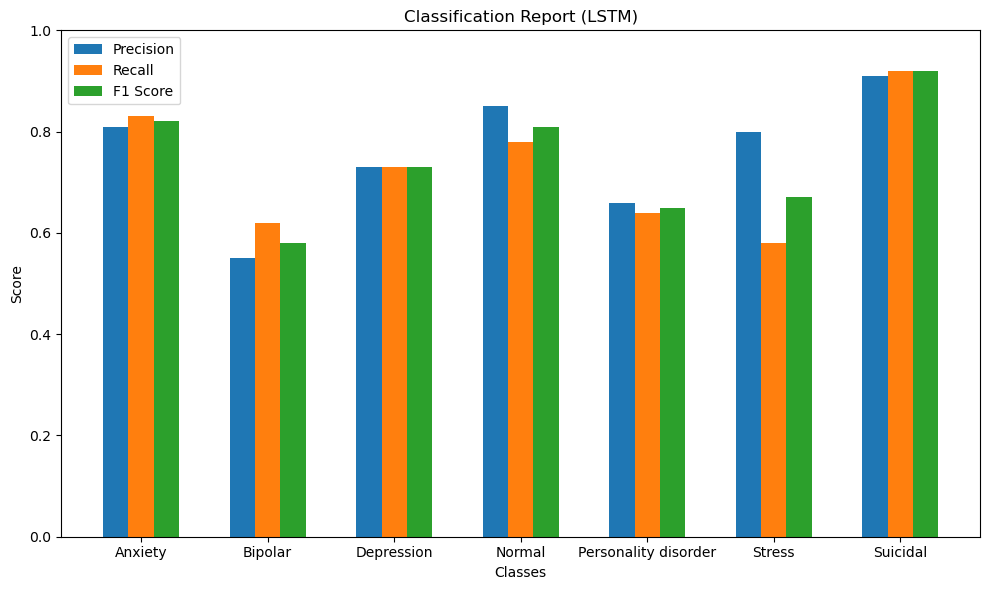

In [40]:
classes = ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']
precision = [0.81, 0.55, 0.73, 0.85, 0.66, 0.80, 0.91]
recall    = [0.83, 0.62, 0.73, 0.78, 0.64, 0.58, 0.92]
f1_score  = [0.82, 0.58, 0.73, 0.81, 0.65, 0.67, 0.92]

x = np.arange(len(classes))
width = 0.2  

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1 Score')

plt.ylabel('Score')
plt.xlabel('Classes')
plt.title('Classification Report (LSTM)')
plt.xticks(x, classes)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()